In [1]:
# pip install ftfy regex tqdm
# pip install git+https://github.com/openai/CLIP.git

In [2]:
import numpy as np
import torch
from pkg_resources import packaging # DEPRECATED

print("Torch version:", torch.__version__)


Torch version: 2.5.1+cpu


C:\Users\cdlar\AppData\Local\Temp\ipykernel_14172\3207500102.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging # DEPRECATED


In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
#model, preprocess = clip.load("ViT-B/32")
#model.cuda().eval()
model, preprocess = clip.load("ViT-B/32", device="cpu") # CPU
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=transforms.InterpolationMode.BICUBIC),  # Resize to input resolution
    transforms.CenterCrop(input_resolution),  # Center crop to input resolution
    transforms.ToTensor(),  # Convert to [C, H, W] format and normalize to [0, 1]
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),  # Normalize
])

In [6]:
long_text = "This is a very long sentence designed to test the behavior of the CLIP tokenizer when the input exceeds the maximum allowed token length. Let's see what happens here."

# Tokenize
tokens = clip.tokenize([long_text])

print(tokens)  # Notice the size will be 77, the max length for ViT-B/32
print(tokens.shape)  # Should be (1, 77)

tensor([[49406,   589,   533,   320,  1070,  1538, 12737,  4486,   531,  1628,
           518, 10461,   539,   518,  9289, 32634, 23895,   827,   518, 16952,
         49353,   518, 13162,  7885, 17134, 10130,   269,  1094,   568,   862,
           768,  4988,   763,   269, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)
torch.Size([1, 77])


In [7]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt

from PIL import Image
from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

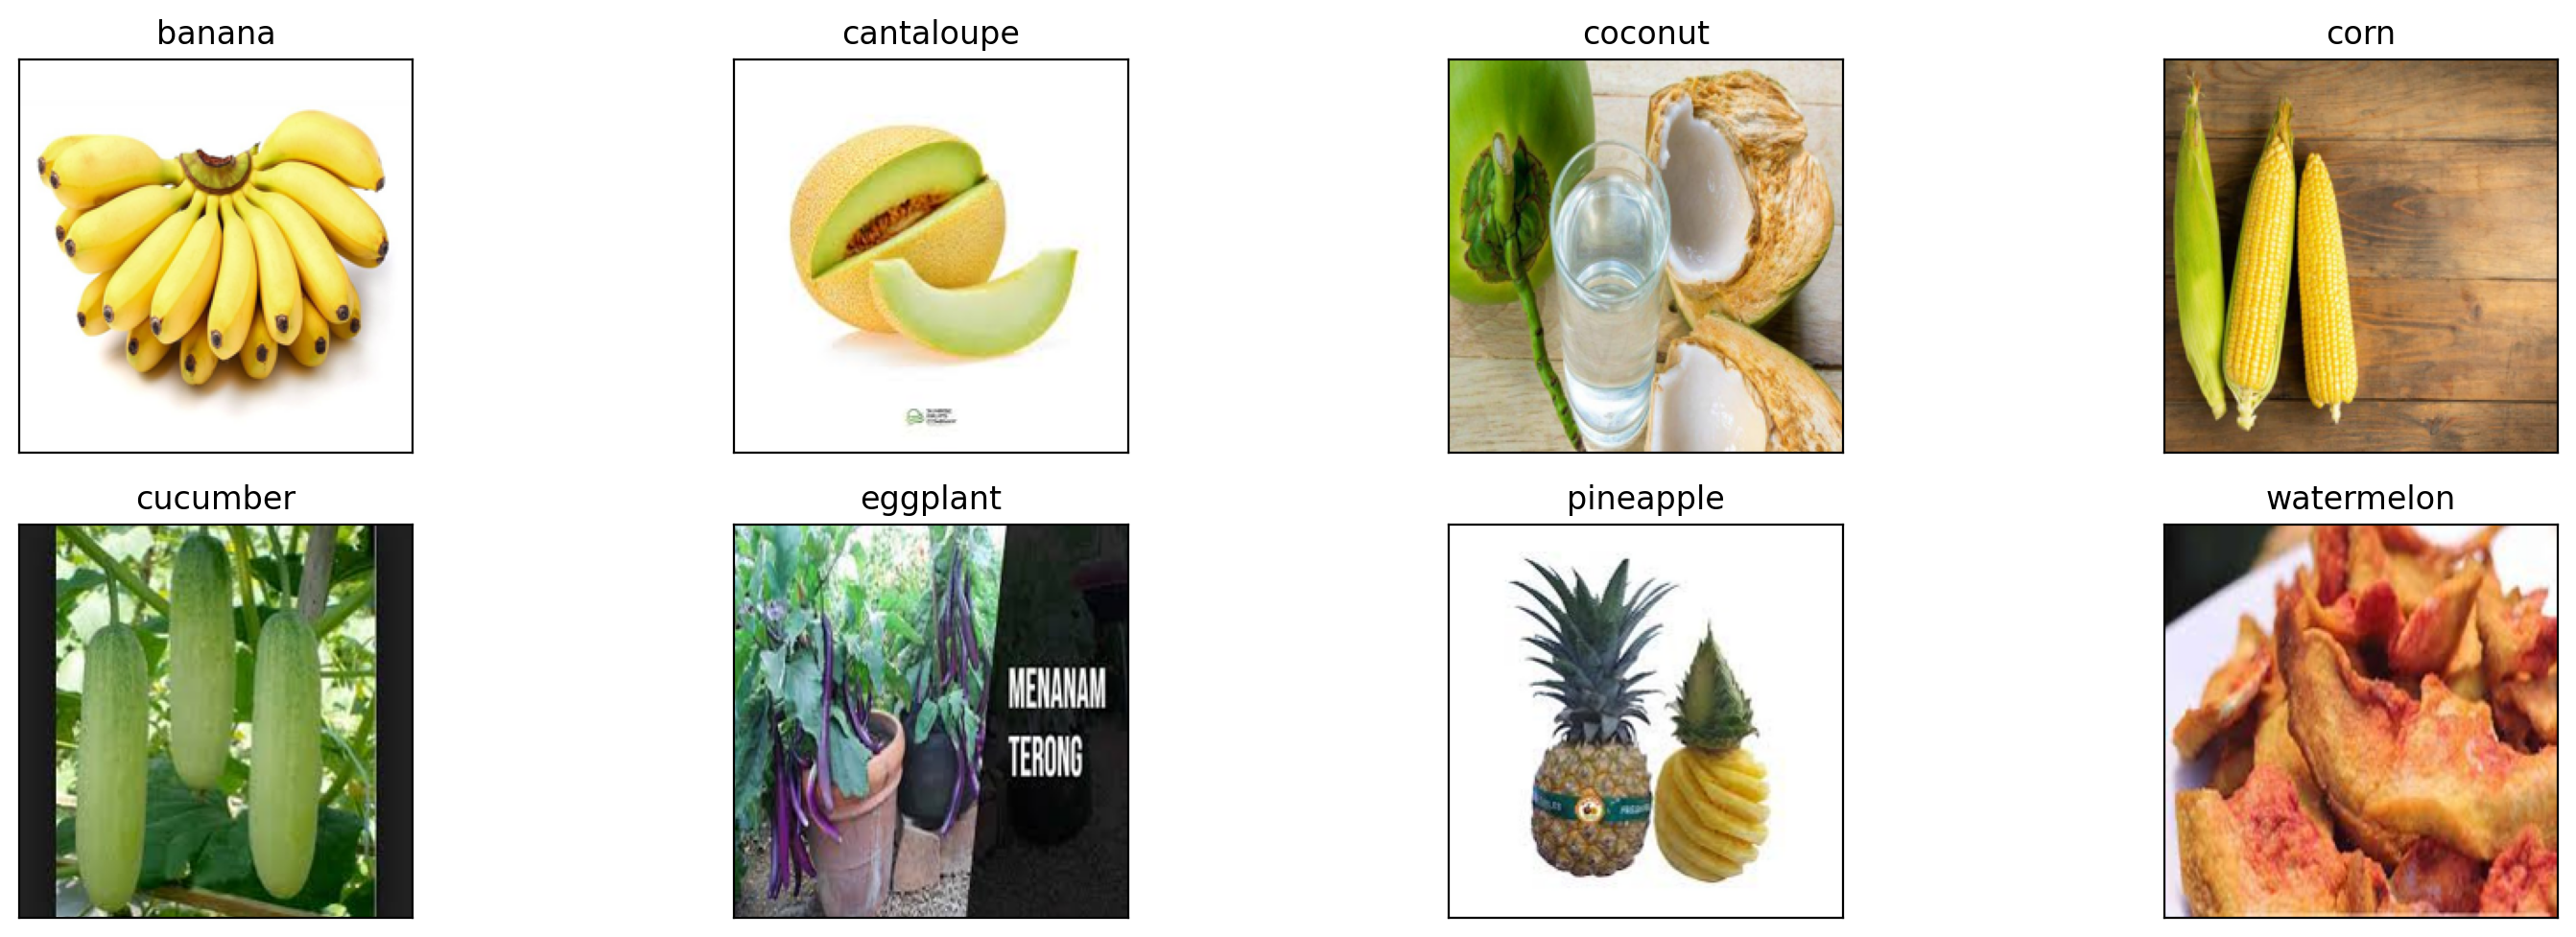

In [15]:
from datasets import load_random_images, load_specific_images

# Paths and directories
dataset_dir = "../dataset" 
split = "train"  # Change to "val" or "test" as needed
num_images = 8
descriptions = []
images = []

images_and_classes = load_random_images(dataset_dir, split, num_images)

classes = ["banana", "cantaloupe", "coconut", "corn", "cucumber", "eggplant", "pineapple", "watermelon"]
images_and_classes = load_specific_images(dataset_dir, split, classes)
# Target dimensions
target_size = (224, 224)

# Plot images in a 4x2 grid
plt.figure(figsize=(16, 5))
for i, (image, description) in enumerate(images_and_classes):
    # Convert to PIL image (if needed) and resize
    pil_image = Image.fromarray(image) if not isinstance(image, Image.Image) else image
    resized_image = pil_image.resize(target_size)
    
    # Convert back to array for plotting
    resized_array = np.array(resized_image)
    
    plt.subplot(2, 4, i + 1)  # 4 rows, 2 columns
    plt.imshow(resized_array)
    plt.title(description)
    # Hide axis
    plt.xticks([])
    plt.yticks([]) 

    descriptions.append(description)
    images.append(resized_array)
    
plt.tight_layout()
plt.show()

In [9]:
print(descriptions)
# First convert NumPy array -> PIL images then preprocess
processed_images = [preprocess(Image.fromarray(image)) for image in images]

image_input = torch.stack(processed_images)  # Shape: [batch_size, 3, input_resolution, input_resolution]
text_tokens = clip.tokenize(["This is " + desc for desc in descriptions])

['banana', 'cantaloupe', 'coconut', 'corn', 'cucumber', 'eggplant', 'pineapple']


In [10]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

print("Image Features:", image_features.shape)
print("Text Features:", text_features.shape)

Image Features: torch.Size([7, 512])
Text Features: torch.Size([7, 512])


In [11]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

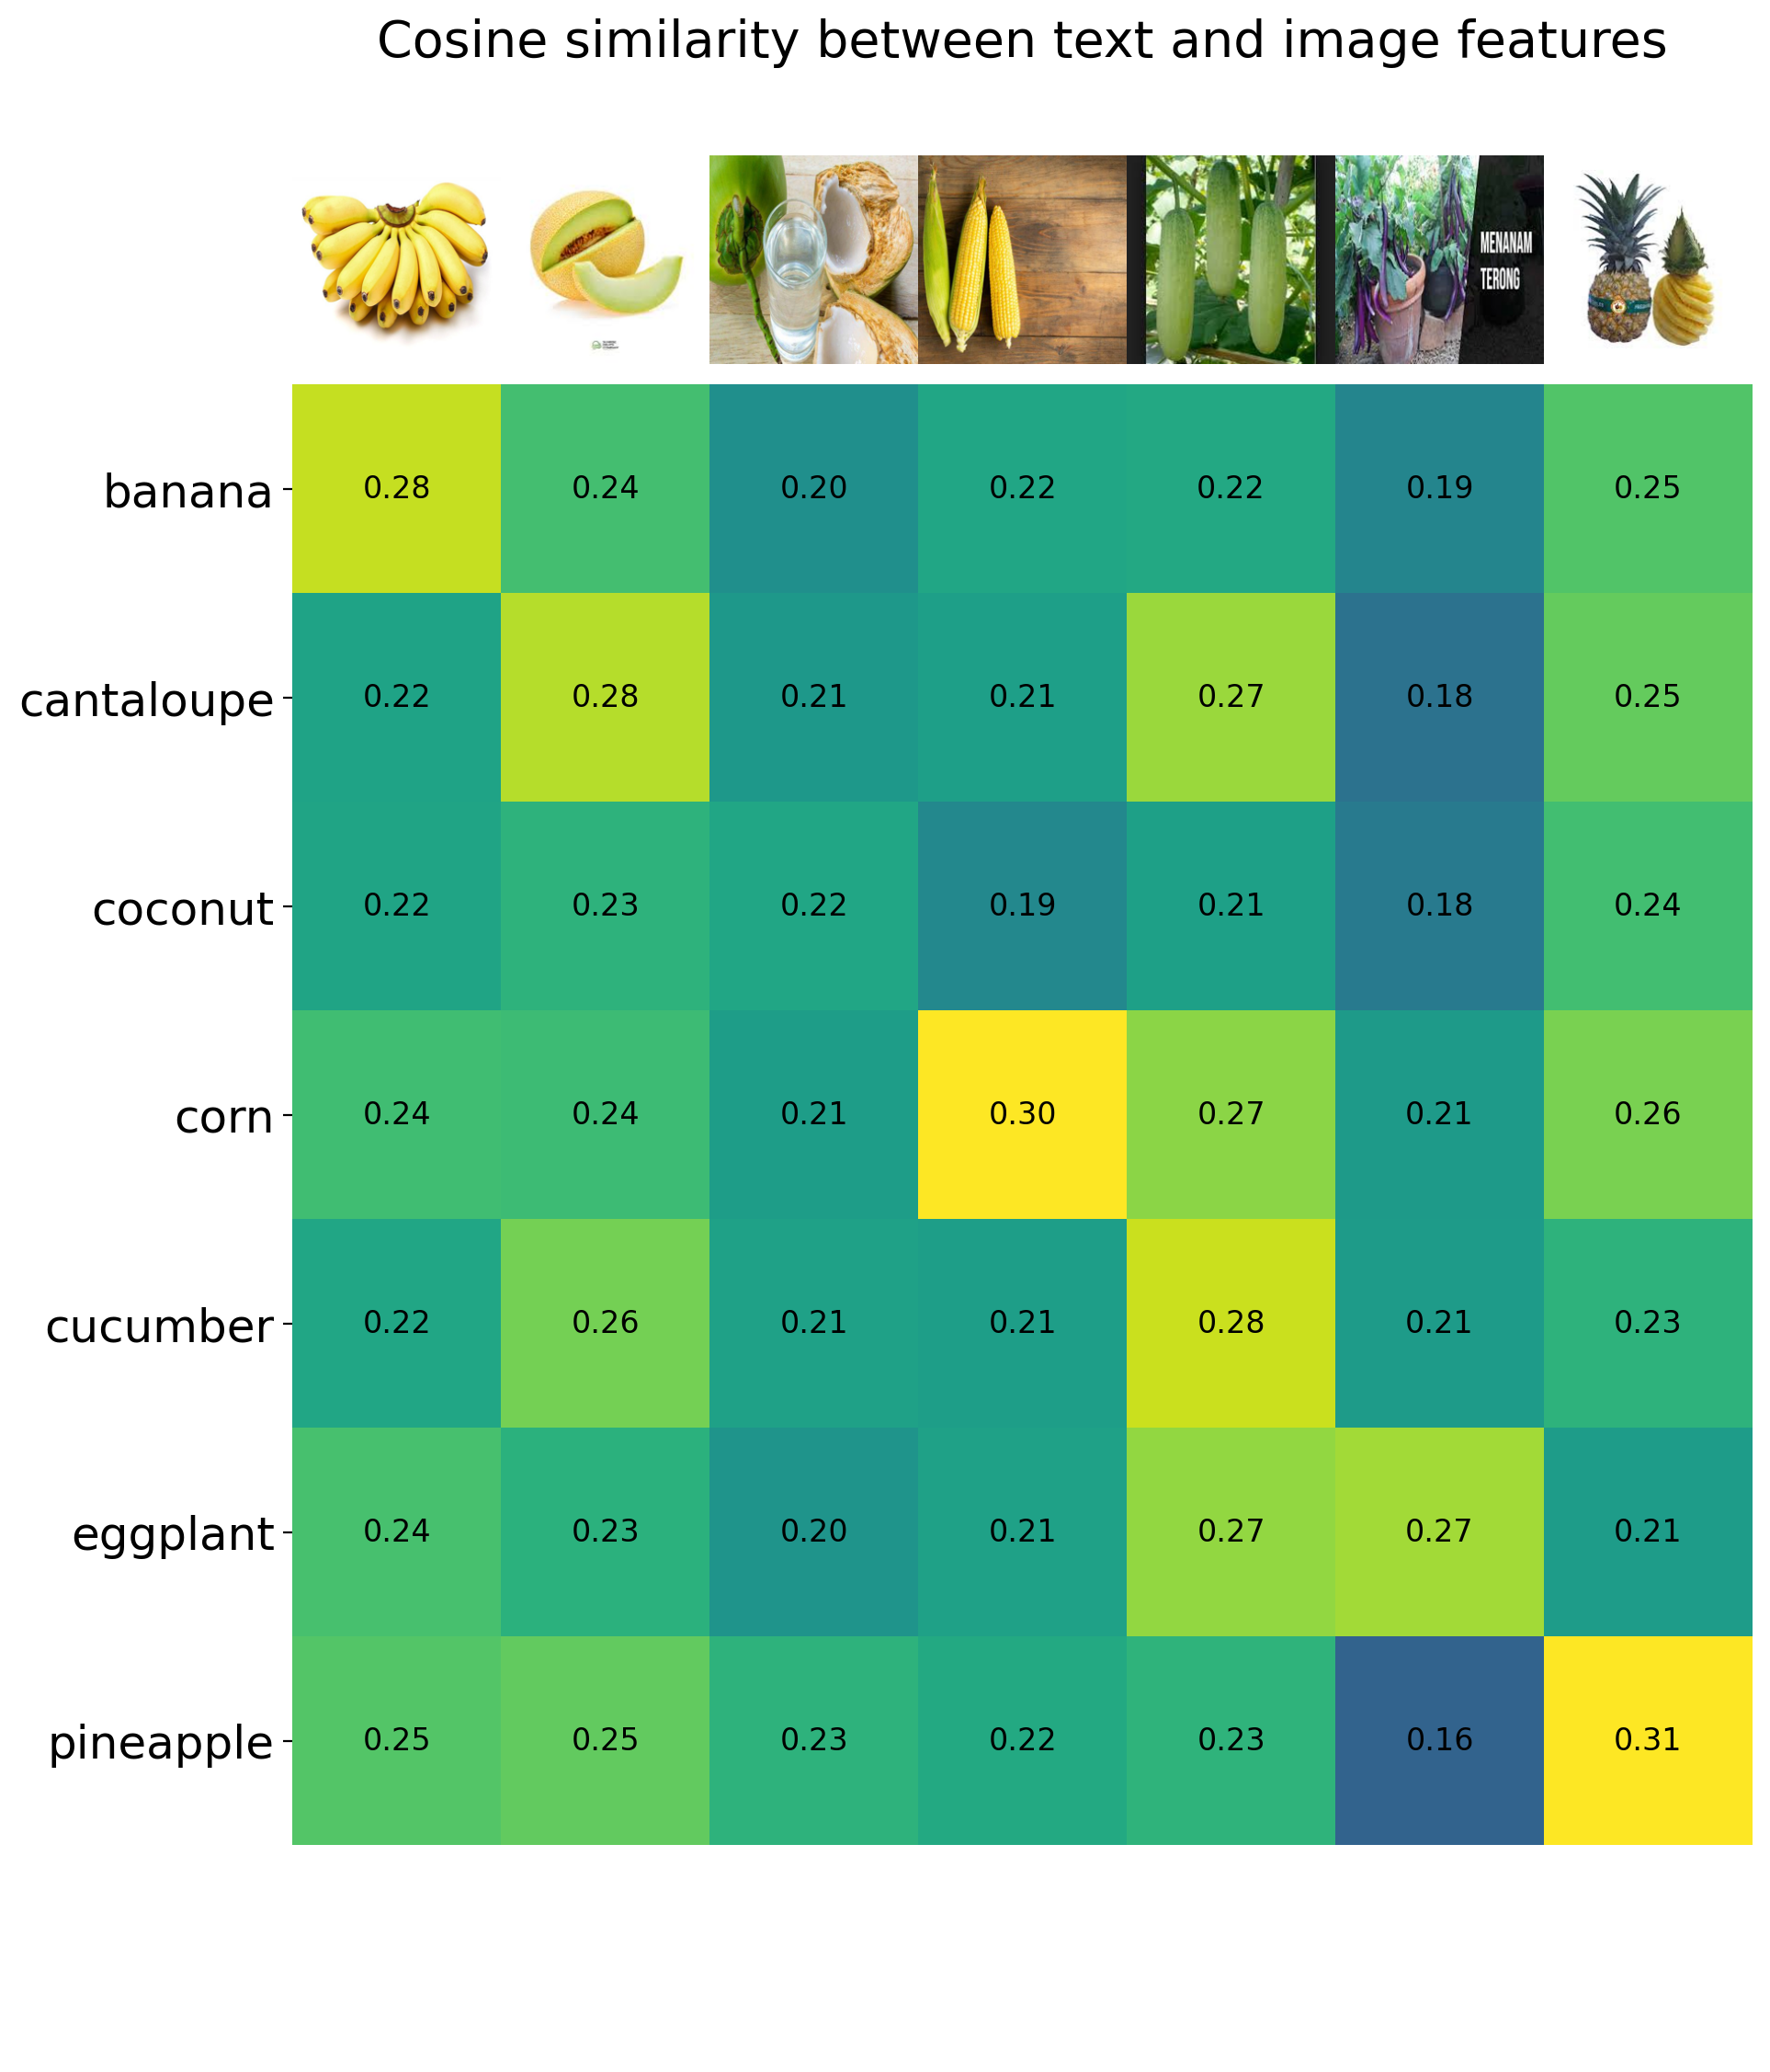

In [12]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), descriptions, fontsize=18)
plt.xticks([])
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)